# 자전거 대여량 예측 모델

# LinearRegression, RandomForestRegressor
# GradientBoostingClassifier, XGBRegressor, LGBMRRegressor

In [19]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#import missingno as msno

%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#분류
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC,SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

#회귀
from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeCV
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

#모델
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

#평가 지표
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error # for regression
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

In [20]:

# 시스템 환경에 따라 폰트를 자동으로 설정해주는 함수
def get_font_family():
    import platform
    system_name = platform.system()

    if system_name == "Darwin":
        return "AppleGothic"
    elif system_name == "Windows":
        return "Malgun Gothic"
    else:
        # Linux (Colab)
        !apt-get install fonts-nanum -qq > /dev/null
        !fc-cache -fv

        import matplotlib as mpl
        mpl.font_manager._rebuild()
        findfont = mpl.font_manager.fontManager.findfont
        mpl.font_manager.findfont = findfont
        mpl.backends.backend_agg.findfont = findfont

        return "NanumBarunGothic"

# 한글 폰트 적용
plt.rc("font", family=get_font_family())
plt.rc("axes", unicode_minus=False)

# 레티나 디스플레이 설정 (선명하게)
%config InlineBackend.figure_format = 'retina'



In [21]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
df=train.copy()
test_df=test.copy()
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [22]:
df.columns.unique()

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

## 컬럼명

datetime - 시간별 날짜 + 타임스탬프

season - 1 = 봄, 2 = 여름, 3 = 가을, 4 = 겨울

holiday - 해당 요일이 휴일인지 여부


workingday - 해당 요일이 주말이나 휴일이 아닌지 여부

weather 

1: 맑음, 구름 조금, 부분적으로 흐림, 부분적으로 흐림
2: 안개 + 흐림, 안개 + 구름 조금, 안개 + 구름 조금, 안개
3: 가벼운 눈, 가벼운 비 + 뇌우 + 흩어진 구름, 가벼운 비 + 흩어진 구름
4: 폭우 + 유빙판 + 뇌우 + 안개, 눈 + 안개

temp - 섭씨 온도

atemp - 체감 온도(섭씨)

humidity - 상대 습도

windspeed - 풍속

casual - 등록되지 않은 사용자 대여 시작 횟수

registered - 등록된 사용자 대여 횟수 시작됨

개수 - 총 대여 횟수

여기서 모든 변수 또는 특성은 숫자형이며, 예측해야 할 대상 변수는 개수 변수입니다. 따라서 개수 변수가 연속형 변수이므로 이는 회귀 문제의 전형적인 예입니다.

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [24]:
# null 값 확인
df.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [25]:
# 계절
df.season.value_counts()

season
4    2734
2    2733
3    2733
1    2686
Name: count, dtype: int64

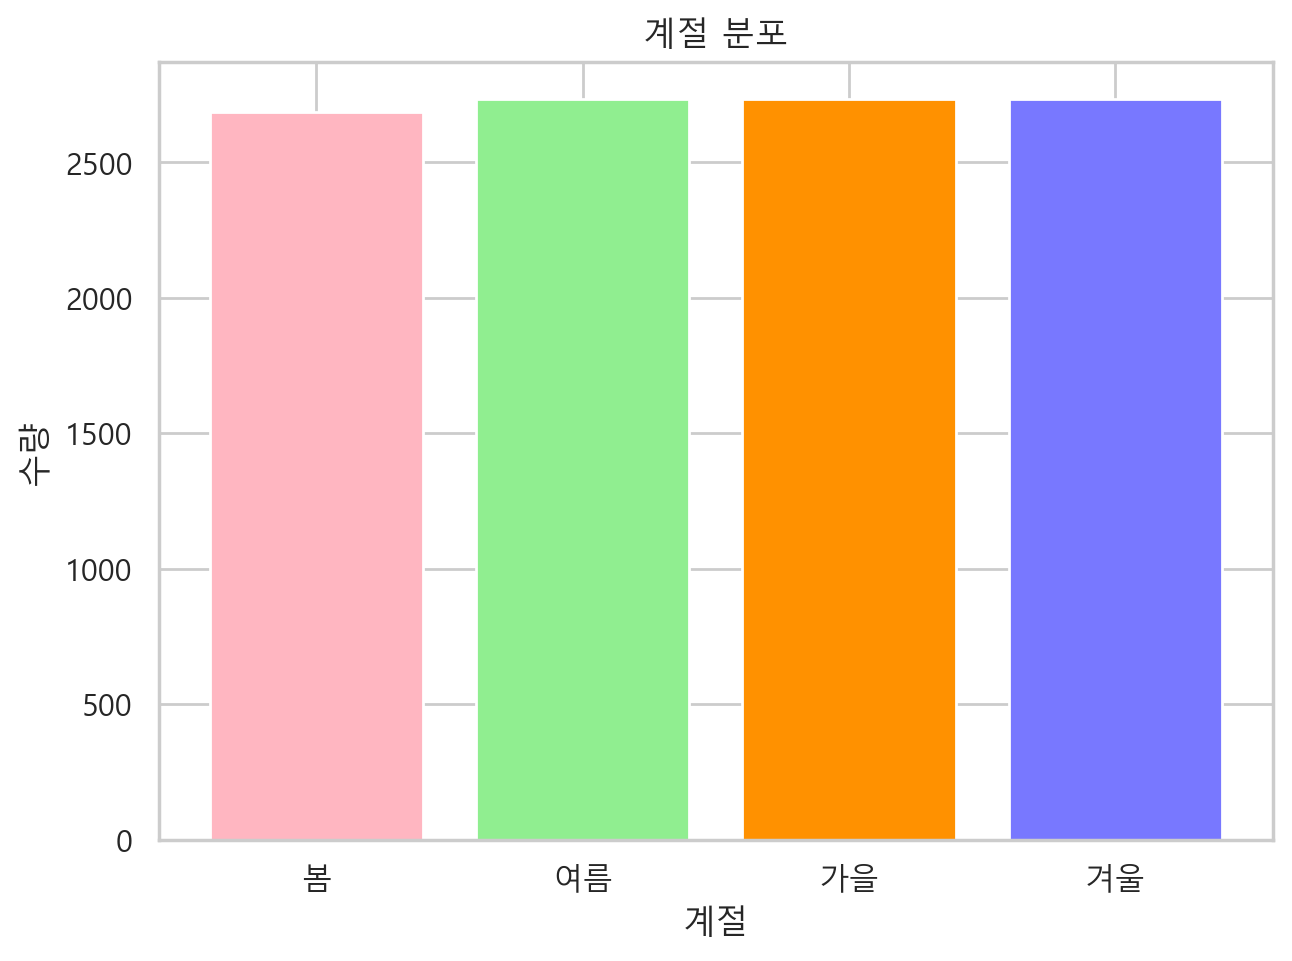

In [28]:
season_counts = df['season'].value_counts().sort_index()
labels = ['봄', '여름', '가을', '겨울']
colors = ['#FFB6C1', '#90EE90', '#FF9100', '#7878FF'] 
plt.bar(labels, season_counts, color=colors)
plt.title('계절 분포')
plt.xlabel('계절')
plt.ylabel('수량')
plt.show()

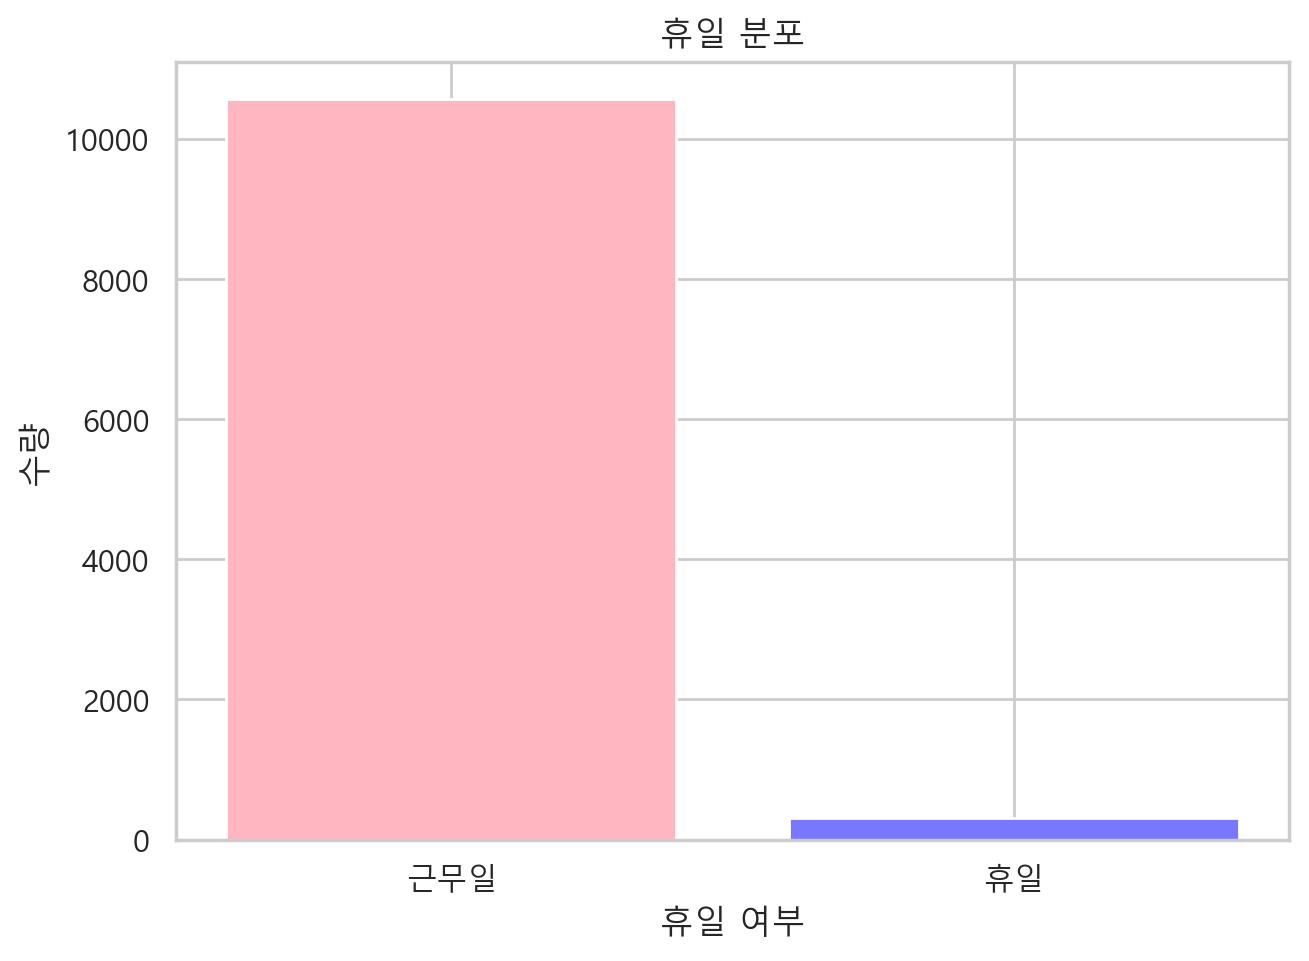

In [35]:
# 휴일
holiday_counts = df['holiday'].value_counts().sort_index()
labels = ['근무일', '휴일']
colors = ['#FFB6C1', '#7878FF'] 
plt.bar(labels, holiday_counts, color=colors)
plt.title('휴일 분포')
plt.xlabel('휴일 여부')
plt.ylabel('수량')
plt.show()

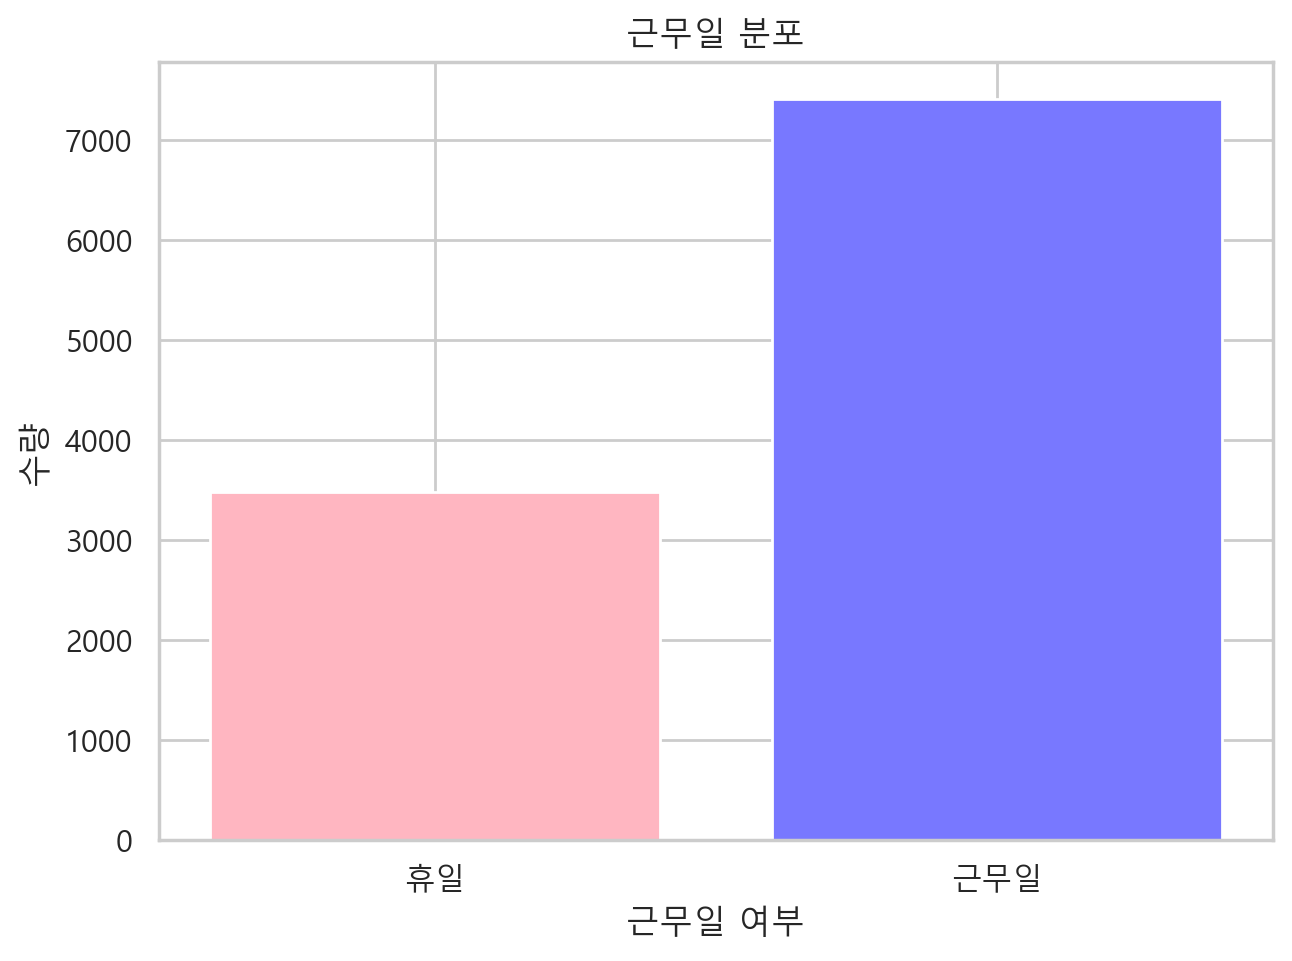

In [36]:
# 근무일
workingday_counts = df['workingday'].value_counts().sort_index()
labels = ['휴일', '근무일']
colors = ['#FFB6C1', '#7878FF'] 
plt.bar(labels, workingday_counts, color=colors)
plt.title('근무일 분포')
plt.xlabel('근무일 여부')
plt.ylabel('수량')
plt.show()

In [41]:
df.drop('datetime',axis=1,inplace=True)
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [43]:
df.columns.to_series().groupby(df.dtypes).groups

{int64: ['season', 'holiday', 'workingday', 'weather', 'humidity', 'casual', 'registered', 'count'], float64: ['temp', 'atemp', 'windspeed']}

In [44]:
x_train,x_test,y_train,y_test=train_test_split(df.drop('count',axis=1),df['count'],test_size=0.25,random_state=42)

In [46]:
models=[RandomForestRegressor(),AdaBoostRegressor(),BaggingRegressor(),SVR(),KNeighborsRegressor()]
model_names=['RandomForestRegressor','AdaBoostRegressor','BaggingRegressor','SVR','KNeighborsRegressor']
rmse=[]
d={}
for model in range (len(models)):
    clf=models[model]
    clf.fit(x_train,y_train)
    test_pred=clf.predict(x_test)
    rmse.append(np.sqrt(mean_squared_log_error(test_pred,y_test)))
d={'Modelling Algo':model_names,'RMSE':rmsle}   
d
    

{'Modelling Algo': ['RandomForestRegressor',
  'AdaBoostRegressor',
  'BaggingRegressor',
  'SVR',
  'KNeighborsRegressor'],
 'RMSE': [np.float64(0.014949716682176139),
  np.float64(0.7433733245652744),
  np.float64(0.019550753837021498),
  np.float64(0.2782345369950399),
  np.float64(0.11314579608295465)]}